# <strong>ISLES'22 Stroke Lesion Segmentation Dataset</strong>

The ISLES 2022 dataset is part of the <strong>Ischemic Stroke Lesion Segmentation Challenge</strong>, which is a benchmark task in medical image analysis. The challenge and dataset aim to push the development of AI systems that can help in identifying and predicting stroke-related damage in the brain using multimodal MRI scans.

### 🧪 What are we doing in the ISLES 2022 task?
The main goals of the ISLES 2022 challenge are:

1. <strong>Lesion Outcome Prediction (Segmentation Task)</strong>
Predict the final infarct area (i.e., the region of brain tissue that will eventually die due to lack of blood flow).

Ground truth masks are provided for training; in testing, models must generalize and predict infarcts from MRI inputs alone.

2. <strong>Patient Triage Classification (Optional Secondary Task)</strong>
Based on imaging, classify whether a patient is a candidate for treatment (e.g., thrombolysis or thrombectomy).

This is a high-level decision support task intended to mimic real-world stroke triage in clinical settings.



## 📦 Step 1: Download the ISLES 2022 Brain Stroke Dataset

In this step, we configure access to Kaggle and download the **ISLES 2022 dataset**, which is used for stroke lesion segmentation and patient triage prediction using multimodal brain MRI scans.

---

### 🧠 About the Dataset

The **ISLES 2022 (Ischemic Stroke Lesion Segmentation)** dataset is a benchmark dataset released as part of a MICCAI challenge. It consists of **multimodal MRI scans** of acute ischemic stroke patients. The three key imaging modalities included are:

- **ADC (Apparent Diffusion Coefficient)**  
- **MTT (Mean Transit Time)**  
- **Tmax (Time-to-Maximum)**  

These modalities are used for:
- 🧠 **Infarct core segmentation** (i.e., identifying dead tissue)
- 📈 **Outcome prediction** (how tissue evolves post-stroke)
- 🧪 **Triage classification** (decision-making support based on imaging)

The dataset is approximately **25GB** in size when unzipped.

> 🔗 **Source**: [Kaggle - ISLES 2022](https://www.kaggle.com/datasets/orvile/isles-2022-brain-stoke-dataset)

---

### ⬇️ Download the Dataset

The dataset will be downloaded and automatically extracted to a local folder (`./isles2022`) for use in your training pipeline or exploratory data analysis.

---

✅ **Once this step is complete, you’ll have access to preprocessed multimodal MRI scans and accompanying metadata ready for model development.**


In [1]:
# Step 1: Upload your Kaggle API key (kaggle.json)
from google.colab import files
print("📁 Please upload your kaggle.json file...")
uploaded = files.upload()

# Step 2: Setup Kaggle CLI configuration
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Step 3: Install Kaggle CLI
!pip install -q kaggle

# Step 4: Download and unzip the ISLES 2022 dataset (~25GB)
dataset_path = "./isles2022"
os.makedirs(dataset_path, exist_ok=True)

print("⬇️ Downloading ISLES 2022 dataset...")
!kaggle datasets download -d orvile/isles-2022-brain-stoke-dataset --unzip -p {dataset_path}

print("✅ Download complete. Dataset saved to:", dataset_path)

📁 Please upload your kaggle.json file...


Saving kaggle.json to kaggle (1).json
⬇️ Downloading ISLES 2022 dataset...
Dataset URL: https://www.kaggle.com/datasets/orvile/isles-2022-brain-stoke-dataset
License(s): other
100% 1.59G/1.59G [00:13<00:00, 278MB/s]
100% 1.59G/1.59G [00:13<00:00, 123MB/s]
✅ Download complete. Dataset saved to: ./isles2022


In [2]:
!pip install -q monai==0.8.1

In [3]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import random
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from monai.networks.nets import UNet

## 🔎 Exploring the Dataset Directory Structure

In this code snippet, we are loading and inspecting the folder structure of the ISLES 2022 dataset after downloading it.

---

### What the code does:

- **Set the dataset path:**  
  The variable `data_dir` points to the root folder where the ISLES 2022 dataset is extracted. This folder contains subfolders for individual patients.

- **List patient folders:**  
  Using the `glob` function combined with a filename pattern (`sub-strokecase*`), we collect and sort all patient-specific directories. Each folder corresponds to a unique stroke case (patient).

- **Print dataset summary:**  
  We output the total number of patient cases found in the directory, as well as show an example folder path of the first patient in the list.

---

### Interpretation of the results:

- **Total patients found: 250**  
  This means there are 250 unique stroke cases (patients) available in the dataset for analysis. Having a substantial number of cases is important for training and validating machine learning models.

- **Example patient folder:**  
  The output shows the path to the first patient’s folder, e.g.,  
  `./isles2022/ISLES-2022/ISLES-2022/sub-strokecase000`  
  This folder typically contains the multimodal MRI scans (ADC, MTT, Tmax) and possibly corresponding annotations for that patient.

---

### Why is this step important?

- **Verify dataset integrity:**  
  Confirming the number of patients and examining folder names ensures the dataset has downloaded and extracted correctly.

- **Prepare for loading data:**  
  Understanding the directory and file structure allows you to write code that loads each patient’s imaging data systematically for further processing, visualization, and modeling.

---

✅ This initial exploration forms the foundation for building your data pipeline and ensures you know exactly what data you have to work with.


## 🩺 Exploring and Analyzing ADC and DWI Files

In [4]:
data_dir = './isles2022/ISLES-2022/ISLES-2022'

subjects = sorted(glob(os.path.join(data_dir, "sub-strokecase*")))

print(f"Total patients found: {len(subjects)}")
print("Example patient folder:", subjects[0])

Total patients found: 250
Example patient folder: ./isles2022/ISLES-2022/ISLES-2022/sub-strokecase0001


In [5]:
import glob
subject_dirs = sorted(glob.glob("./isles2022/ISLES-2022/ISLES-2022/sub-strokecase*/ses-*"))

print(f"✅ Total session folders found: {len(subject_dirs)}")

if subject_dirs:
    print("🔍 Example session folder:", subject_dirs[0])
else:
    print("❌ No session folders found — check path again")


✅ Total session folders found: 250
🔍 Example session folder: ./isles2022/ISLES-2022/ISLES-2022/sub-strokecase0001/ses-0001


In [6]:
base_path = "./isles2022/ISLES-2022/ISLES-2022"
patients = sorted([d for d in os.listdir(base_path) if d.startswith("sub-")])

adc_paths = []
dwi_paths = []

for patient in patients:
    dwi_dir = os.path.join(base_path, patient, "ses-0001", "dwi")

    if os.path.isdir(dwi_dir):
        # Step 1: Find all folders ending with .nii inside dwi/
        nii_folders = [f for f in glob.glob(os.path.join(dwi_dir, "*.nii")) if os.path.isdir(f)]

        # Step 2: For each folder, look inside for actual .nii files
        for nii_folder in nii_folders:
            actual_nii_files = glob.glob(os.path.join(nii_folder, "*.nii"))

            for f in actual_nii_files:
                fname_lower = os.path.basename(f).lower()
                if "adc" in fname_lower:
                    adc_paths.append(f)
                elif "dwi" in fname_lower:
                    dwi_paths.append(f)

print(f"✅ Total ADC files found: {len(adc_paths)}")
print(f"✅ Total DWI files found: {len(dwi_paths)}")

# Preview one example of each (if available)
if adc_paths:
    print("📄 Example ADC file:", adc_paths[0])
if dwi_paths:
    print("📄 Example DWI file:", dwi_paths[0])


✅ Total ADC files found: 240
✅ Total DWI files found: 250
📄 Example ADC file: ./isles2022/ISLES-2022/ISLES-2022/sub-strokecase0001/ses-0001/dwi/sub-strokecase0001_ses-0001_adc.nii/sub-strokeperf0041_ses-20180528_ornt-2iso_skull-stripped_sequ-306_adc.nii
📄 Example DWI file: ./isles2022/ISLES-2022/ISLES-2022/sub-strokecase0001/ses-0001/dwi/sub-strokecase0001_ses-0001_dwi.nii/sub-strokeperf0041_ses-20180528_ornt-2iso_skull-stripped_sequ-307_dwi.nii


In [8]:
import glob
base_path = "./isles2022/ISLES-2022/ISLES-2022"
patients = sorted([d for d in os.listdir(base_path) if d.startswith("sub-")])

adc_paths = []
dwi_paths = []

for patient in patients:
    dwi_dir = os.path.join(base_path, patient, "ses-0001", "dwi")

    if os.path.isdir(dwi_dir):
        # Step 1: Find all folders ending with .nii inside dwi/
        nii_folders = [f for f in glob.glob(os.path.join(dwi_dir, "*.nii")) if os.path.isdir(f)]

        # Step 2: For each folder, look inside for actual .nii files
        for nii_folder in nii_folders:
            actual_nii_files = glob.glob(os.path.join(nii_folder, "*.nii"))

            for f in actual_nii_files:
                fname_lower = os.path.basename(f).lower()
                if "adc" in fname_lower:
                    adc_paths.append(f)
                elif "dwi" in fname_lower:
                    dwi_paths.append(f)

print(f"✅ Total ADC files found: {len(adc_paths)}")
print(f"✅ Total DWI files found: {len(dwi_paths)}")

# Preview one example of each (if available)
if adc_paths:
    print("📄 Example ADC file:", adc_paths[0])
if dwi_paths:
    print("📄 Example DWI file:", dwi_paths[0])


✅ Total ADC files found: 240
✅ Total DWI files found: 250
📄 Example ADC file: ./isles2022/ISLES-2022/ISLES-2022/sub-strokecase0001/ses-0001/dwi/sub-strokecase0001_ses-0001_adc.nii/sub-strokeperf0041_ses-20180528_ornt-2iso_skull-stripped_sequ-306_adc.nii
📄 Example DWI file: ./isles2022/ISLES-2022/ISLES-2022/sub-strokecase0001/ses-0001/dwi/sub-strokecase0001_ses-0001_dwi.nii/sub-strokeperf0041_ses-20180528_ornt-2iso_skull-stripped_sequ-307_dwi.nii


## 📂 Loading and Inspecting MRI Images in NIfTI Format

---

### What this code does:

- **Function `load_nifti(path)`**  
  This function is designed to load medical imaging data stored in **NIfTI (.nii or .nii.gz) format**, which is a common format for MRI scans.

  - It first checks if the file exists at the specified `path`. If the file is missing, it raises a clear error.
  - Then it uses the `nibabel` library (`nib`) to load the image.
  - The function extracts the actual image data as a NumPy array using `get_fdata()`, which can be used for further analysis or modeling.
  - It returns both the raw image data array and the full image object (which contains metadata like affine transforms, header info).
  - If any error occurs during loading, it catches the exception, prints an error message, and returns `None` values.

---

### Example usage:

- The code loads two MRI modalities for the same patient:
  - `adc_data` and `adc_img` for the **ADC** modality
  - `dwi_data` and `dwi_img` for the **DWI** modality

- It then checks if both files loaded successfully before printing their shapes.

---

### Interpretation of the results:

- **Output:**  

  - ADC shape: (112, 112, 73)
  - DWI shape: (112, 112, 73)

  
  This indicates:
  - Both ADC and DWI images are 3D volumes with dimensions 112×112 pixels per slice and 73 slices in depth.
  - Having consistent shapes across modalities is crucial for multimodal analysis and ensures proper spatial alignment during model training or visualization.

---

### Why this step is important?

- **Loading images properly:**  
  Medical images stored in NIfTI format need to be loaded correctly to preserve spatial and intensity information.

- **Error handling:**  
  The function gracefully handles missing or corrupted files, helping to debug dataset issues early.

- **Foundation for downstream tasks:**  
  Once loaded, these arrays can be processed (e.g., normalization, cropping), visualized, or passed to deep learning models for stroke lesion segmentation or prediction.

---

✅ This function forms a core utility for working with medical imaging data in your stroke analysis pipeline.

In [9]:
def load_nifti(path):
    if not os.path.isfile(path):
        raise FileNotFoundError(f"File not found: {path}")
    try:
        img = nib.load(path)
        data = img.get_fdata()
        return data, img
    except Exception as e:
        print(f"Error loading {path}: {e}")
        return None, None

# Example usage:
adc_data, adc_img = load_nifti(adc_paths[0])
dwi_data, dwi_img = load_nifti(dwi_paths[0])

if adc_data is not None and dwi_data is not None:
    print(f"ADC shape: {adc_data.shape}")
    print(f"DWI shape: {dwi_data.shape}")
else:
    print("Failed to load one or both files.")


ADC shape: (112, 112, 73)
DWI shape: (112, 112, 73)


## 🖼️ Visualizing MRI Volumes with Middle Slices

---

### What this code does:

- **Function `plot_middle_slices(volume, title, cmap='gray')`**  
  This function visualizes a 3D medical image volume by extracting and displaying the **middle slice** along each of the three anatomical planes:
  
  1. **Axial plane:** Horizontal slice dividing top and bottom (looking from above).
  2. **Coronal plane:** Vertical slice dividing front and back.
  3. **Sagittal plane:** Vertical slice dividing left and right.

- The function calculates the middle index for each dimension of the volume and plots these slices side-by-side using Matplotlib.

- The images use a grayscale colormap (`cmap='gray'`), which is standard for MRI visualization.

---

### What to expect in the final images:

- Since this is applied to both **ADC** and **DWI** modalities, you will see **6 images in total**:
  - 3 middle slices for the ADC volume: Axial, Coronal, Sagittal views.
  - 3 middle slices for the DWI volume: Axial, Coronal, Sagittal views.

- These slices represent the "central" cross-sections of the brain scan and help you visually inspect:
  - The overall anatomy and structure of the brain.
  - Contrast differences indicating possible stroke lesions or abnormalities.
  - Image quality and alignment across modalities.

---

### Why this step is important:

- **Quick visual check:**  
  Plotting middle slices provides a straightforward way to verify if the MRI data loaded correctly and looks anatomically plausible.

- **Insight into modality differences:**  
  ADC and DWI highlight different tissue characteristics related to stroke pathology. Comparing their slices helps understand what each modality reveals.

- **Foundation for further analysis:**  
  Visual inspection guides preprocessing decisions and can detect issues like misalignment, artifacts, or empty scans early on.

---

✅ Viewing these images is a key early step in your pipeline, ensuring the data is ready for segmentation, modeling, or clinical interpretation.

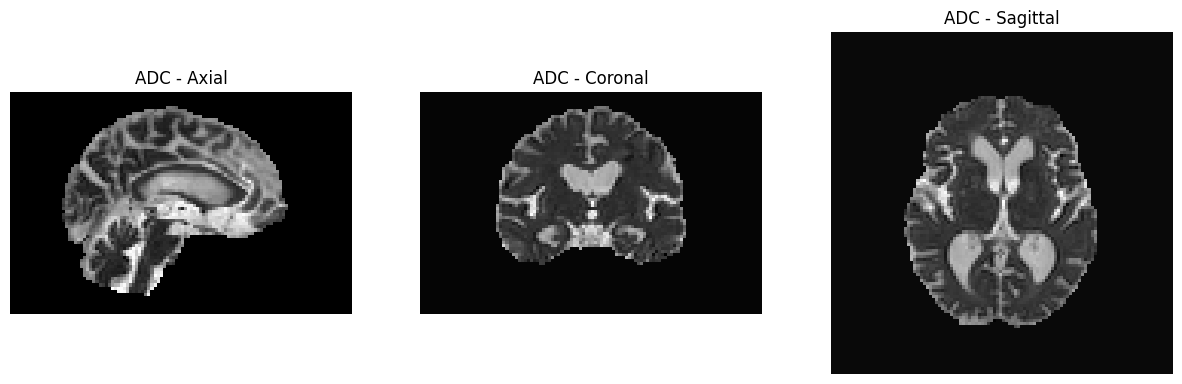

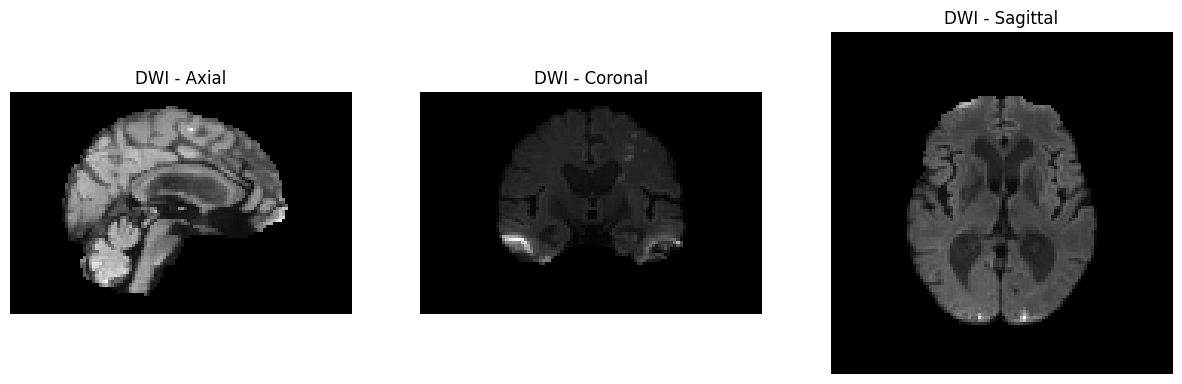

In [10]:
def plot_middle_slices(volume, title, cmap='gray'):
    mid_slices = [volume.shape[0]//2, volume.shape[1]//2, volume.shape[2]//2]

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(volume[mid_slices[0], :, :].T, cmap=cmap, origin='lower')
    axs[0].set_title(f'{title} - Axial')
    axs[0].axis('off')

    axs[1].imshow(volume[:, mid_slices[1], :].T, cmap=cmap, origin='lower')
    axs[1].set_title(f'{title} - Coronal')
    axs[1].axis('off')

    axs[2].imshow(volume[:, :, mid_slices[2]].T, cmap=cmap, origin='lower')
    axs[2].set_title(f'{title} - Sagittal')
    axs[2].axis('off')

    plt.show()

plot_middle_slices(adc_data, 'ADC')
plot_middle_slices(dwi_data, 'DWI')

## 📊 Analyzing Intensity Statistics of MRI Volumes

---

### What this code does:

- **Function `print_intensity_stats(volume, name)`**  
  This function calculates and prints key statistical measures of the voxel intensities within a 3D MRI volume:

  - **Mean:** Average intensity value across all voxels.
  - **Standard Deviation (Std):** Measures the spread or variability of intensities.
  - **Minimum (Min):** Lowest intensity value in the volume.
  - **Maximum (Max):** Highest intensity value in the volume.

- It then calls this function separately for the **ADC** and **DWI** volumes to summarize their intensity distributions.

---

### Interpretation of the results:

```
ADC intensity stats:
  Mean: 0.2320
  Std:  0.6345
  Min:  -0.2844
  Max:  4.7183

DWI intensity stats:
  Mean: 35.1104
  Std:  87.5583
  Min:  -10.1593
  Max:  1881.3452
```

- **ADC Volume:**  
  - The mean is close to zero, with relatively small standard deviation and intensity values mostly centered near zero.  
  - The intensity range is narrow compared to DWI, typical of ADC maps which quantify water diffusion.

- **DWI Volume:**  
  - Shows much higher mean and standard deviation values, indicating a wider range and larger variation of intensities.  
  - The maximum intensity is very high, reflecting the nature of diffusion-weighted imaging, which can have strong signal intensities in affected brain regions.

- **Negative intensity values:**  
  - Both volumes have small negative minimum values, which may arise from preprocessing or scanner noise and usually require normalization or clipping before model training.

---

### Why this step is important:

- **Understand data distribution:**  
  Knowing intensity ranges and variability helps in choosing proper preprocessing steps such as normalization, scaling, or clipping.

- **Detect outliers or anomalies:**  
  Extremely high or low values may indicate artifacts, noise, or issues in image acquisition.

- **Facilitate model training:**  
  Consistent and well-understood intensity statistics improve model convergence and performance.

---

✅ This statistical summary is a key data quality check and informs all subsequent image preprocessing and analysis steps.


In [11]:
def print_intensity_stats(volume, name):
    print(f"{name} intensity stats:")
    print(f"  Mean: {volume.mean():.4f}")
    print(f"  Std:  {volume.std():.4f}")
    print(f"  Min:  {volume.min():.4f}")
    print(f"  Max:  {volume.max():.4f}")

print_intensity_stats(adc_data, 'ADC')
print_intensity_stats(dwi_data, 'DWI')

ADC intensity stats:
  Mean: 0.2320
  Std:  0.6345
  Min:  -0.2844
  Max:  4.7183
DWI intensity stats:
  Mean: 35.1104
  Std:  87.5583
  Min:  -10.1593
  Max:  1881.3452


## 📈 Visualizing Intensity Distributions with Histograms

---

### What this code does:

- **Function `plot_histogram(volume, title, bins=100)`**  
  This function plots the distribution of voxel intensities within a 3D MRI volume as a histogram.

- It flattens the 3D image into a 1D array of intensity values and groups these into bins (default 100).

- Separate histograms are plotted for the **ADC** and **DWI** volumes to compare their intensity distributions visually.

---

### Interpretation of the histograms:

#### 1. **ADC Intensities Histogram**

- The histogram shows a **very high voxel count near intensity 0**, indicating that most of the brain volume has low ADC intensity values.
- A smaller peak appears near intensity 1.
- There are relatively few voxels with intensities greater than 2 or 3, forming smaller "tails" in the histogram.
- This is consistent with ADC representing diffusion restriction, where healthy brain tissue and cerebrospinal fluid dominate, while lesions occupy fewer voxels.

The detailed voxel counts in ranges confirm this:
- The vast majority of voxels (over 769,000) lie between roughly -0.03 and 0.22 intensity.
- Counts progressively decrease as intensity increases beyond 0.5, indicating less common high ADC values.

#### 2. **DWI Intensities Histogram**

- Also shows a **large peak at intensity 0**, reflecting background or non-lesion tissue.
- Another noticeable peak around intensity ~250 indicates a cluster of voxels with elevated diffusion-weighted signal, likely corresponding to stroke lesions or abnormal tissue.
- The distribution is more spread out with long tails reaching intensities above 1800, reflecting high-intensity signal regions typical in DWI scans of stroke patients.

Looking at the counts:
- Nearly 780,000 voxels fall in the lower intensity range (-10 to ~84).
- Significant counts remain in the mid-range bins (up to 370 intensity).
- Few voxels have extremely high intensities, but these can be clinically significant.

---

### Why this step is important:

- **Characterizing voxel intensity distribution** helps in understanding the data's nature and heterogeneity.
- It guides preprocessing choices like:
  - Intensity normalization or standardization,
  - Clipping of extreme outliers,
  - Identifying meaningful intens


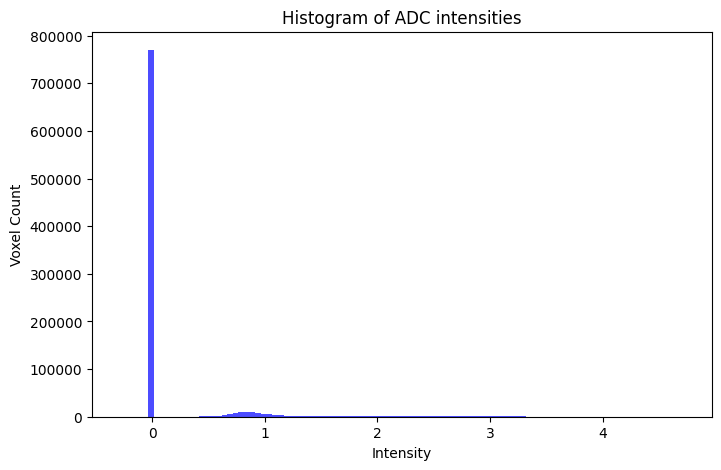

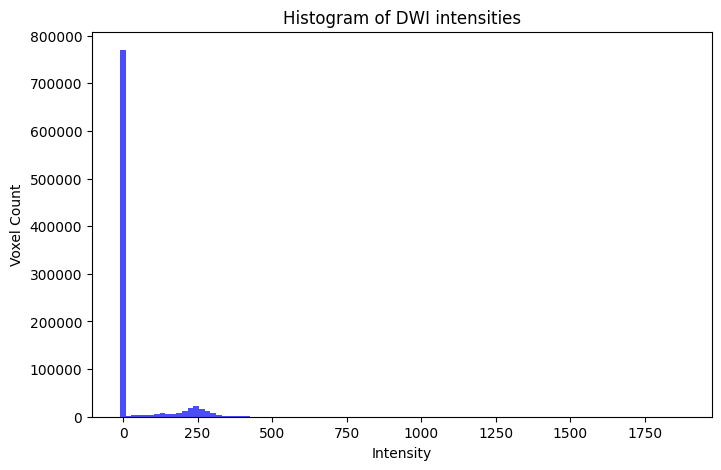

In [12]:
def plot_histogram(volume, title, bins=100):
    plt.figure(figsize=(8,5))
    plt.hist(volume.flatten(), bins=bins, color='blue', alpha=0.7)
    plt.title(f"Histogram of {title} intensities")
    plt.xlabel("Intensity")
    plt.ylabel("Voxel Count")
    plt.show()

plot_histogram(adc_data, "ADC")
plot_histogram(dwi_data, "DWI")

In [13]:
def intensity_value_counts(volume, bins=20):
    vals = volume.flatten()

    counts, bin_edges = np.histogram(vals, bins=bins)

    bin_ranges = [f"{bin_edges[i]:.3f} to {bin_edges[i+1]:.3f}" for i in range(len(bin_edges)-1)]
    df = pd.DataFrame({"Intensity Range": bin_ranges, "Voxel Count": counts})

    return df

adc_counts_df = intensity_value_counts(adc_data, bins=20)
dwi_counts_df = intensity_value_counts(dwi_data, bins=20)

print("ADC intensity counts:")
print(adc_counts_df)

print("\nDWI intensity counts:")
print(dwi_counts_df)

ADC intensity counts:
     Intensity Range  Voxel Count
0   -0.284 to -0.034           30
1    -0.034 to 0.216       769879
2     0.216 to 0.466         1806
3     0.466 to 0.716        14183
4     0.716 to 0.966        47135
5     0.966 to 1.216        20163
6     1.216 to 1.467        10009
7     1.467 to 1.717         8214
8     1.717 to 1.967         7591
9     1.967 to 2.217         7007
10    2.217 to 2.467         6218
11    2.467 to 2.717         5469
12    2.717 to 2.967         5424
13    2.967 to 3.217         6733
14    3.217 to 3.468         2232
15    3.468 to 3.718         1061
16    3.718 to 3.968          910
17    3.968 to 4.218          793
18    4.218 to 4.468          538
19    4.468 to 4.718          317

DWI intensity counts:
         Intensity Range  Voxel Count
0      -10.159 to 84.416       779801
1      84.416 to 178.991        28569
2     178.991 to 273.566        76356
3     273.566 to 368.142        27173
4     368.142 to 462.717         3125
5     462.717

## 📐 Checking Variability in MRI Volume Dimensions

---

### What this code does:

- For each file path in the ADC and DWI modality lists (`adc_paths` and `dwi_paths`), the code loads the corresponding NIfTI volume using the `load_nifti` function.

- It extracts the **shape** (dimensions) of each 3D volume and collects these shapes into two separate lists: one for ADC volumes, one for DWI volumes.

- The code then prints the unique set of shapes found for each modality to identify how consistent the volume dimensions are across patients.

---

### Interpretation of the results:

- **Multiple unique shapes exist for both ADC and DWI volumes**, indicating variability in spatial resolution or scan coverage among patients.

- Example shapes found include:  
  - (112, 112, 75)  
  - (192, 192, 30)  
  - (130, 130, 65)  
  - (256, 256, 73)  
  - and others...

- This means the dataset contains volumes with different in-plane resolutions (e.g., 112x112 vs. 256x256 pixels) and varying numbers of slices (depth), reflecting variability in scanning protocols or patient anatomy.

---

### Why this step is important:

- **Consistency check:**  
  Identifying shape variability early helps plan preprocessing steps such as resampling or resizing to a common shape for model input.

- **Handling heterogeneity:**  
  Medical imaging datasets often include scans acquired from different machines or settings. Knowing the shape diversity allows designing a robust pipeline.

- **Prevent errors downstream:**  
  Models expect fixed-size inputs, so inconsistent shapes must be standardized or padded before training.

---

✅ This step highlights the need for shape normalization in your pipeline to ensure consistent input data for modeling stroke lesion segmentation or outcome prediction.

In [14]:
adc_shapes = [load_nifti(p)[0].shape for p in adc_paths]
dwi_shapes = [load_nifti(p)[0].shape for p in dwi_paths]

print("ADC unique shapes:", set(adc_shapes))
print("DWI unique shapes:", set(dwi_shapes))

ADC unique shapes: {(112, 112, 75), (192, 192, 30), (130, 130, 65), (128, 128, 30), (112, 112, 74), (128, 128, 72), (256, 256, 73), (128, 128, 27), (128, 128, 25), (170, 170, 33), (112, 112, 73), (115, 115, 70), (115, 115, 28), (112, 112, 76), (112, 112, 72), (122, 122, 63)}
DWI unique shapes: {(112, 112, 75), (192, 192, 30), (115, 115, 75), (130, 130, 65), (128, 128, 30), (112, 112, 74), (128, 128, 72), (256, 256, 73), (128, 128, 27), (128, 128, 25), (170, 170, 33), (112, 112, 73), (115, 115, 70), (115, 115, 28), (112, 112, 76), (112, 112, 72), (122, 122, 63)}


## 📊 Visualizing Intensity Distributions: CDF and Boxplot

---

### 1. Cumulative Distribution Function (CDF) Plot

- **Purpose:**  
  The CDF plot shows the cumulative probability of voxel intensities in the volume. It represents the proportion of voxels with intensity values less than or equal to a given intensity.

- **How it works:**  
  - Flatten the 3D volume into a 1D array of intensities.
  - Sort the intensities in ascending order.
  - Calculate the cumulative fraction of voxels at or below each intensity.
  - Plot intensity values on the x-axis and cumulative probability (0 to 1) on the y-axis.

- **Interpretation:**  
  - Steeper rises in the curve indicate intensity ranges where many voxels are concentrated.
  - Flat areas indicate intensity ranges with few voxels.
  - You can quickly estimate intensity thresholds (e.g., median intensity is where CDF crosses 0.5).

- **Applied to ADC and DWI:**  
  This plot helps compare how intensities accumulate in different MRI modalities and understand tissue distribution differences.

---

### 2. Boxplot of Intensity Values

- **Purpose:**  
  The boxplot provides a statistical summary of the intensity distribution, showing median, quartiles, and potential outliers.

- **How it works:**  
  - Flatten the volume into a 1D intensity array.
  - Plot the distribution vertically with:
    - The box showing the interquartile range (IQR, from 25th to 75th percentile).
    - The line inside the box showing the median intensity.
    - Whiskers extending to capture the range of non-outlier data.
    - Outliers plotted as individual points beyond the whiskers.

- **Interpretation:**  
  - The median gives the central tendency.
  - The spread (IQR) shows variability.
  - Outliers highlight extreme intensities, which may be noise or meaningful lesion signals.
  - Comparing boxplots for ADC and DWI reveals differences in intensity variability and presence of outliers.

---

### Why these visualizations matter:

- Together, CDF and boxplots offer complementary views on the data distribution:
  - **CDF** emphasizes cumulative probability and helps determine thresholds.
  - **Boxplot** highlights spread, central tendency, and outliers succinctly.

- Understanding these helps in designing preprocessing steps like clipping, normalization, or thresholding for segmentation.

---

✅ Using these plots enhances your insight into MRI intensity patterns critical for ischemic stroke lesion analysis and model development.

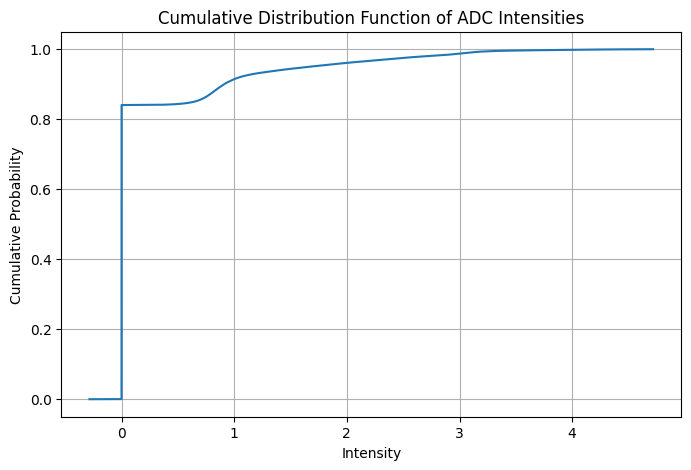

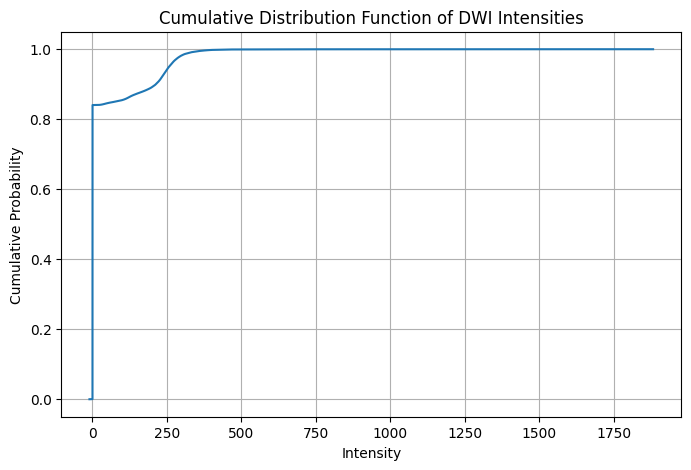

In [15]:
def plot_cdf(volume, title):
    vals = volume.flatten()
    sorted_vals = np.sort(vals)
    cdf = np.arange(len(sorted_vals)) / float(len(sorted_vals))

    plt.figure(figsize=(8,5))
    plt.plot(sorted_vals, cdf, label='CDF')
    plt.title(f'Cumulative Distribution Function of {title} Intensities')
    plt.xlabel('Intensity')
    plt.ylabel('Cumulative Probability')
    plt.grid(True)
    plt.show()

plot_cdf(adc_data, "ADC")
plot_cdf(dwi_data, "DWI")

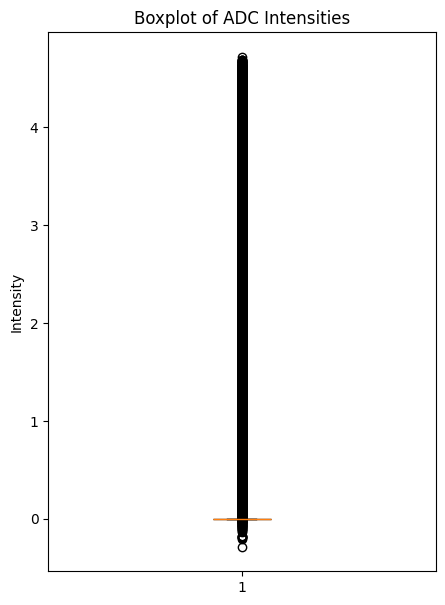

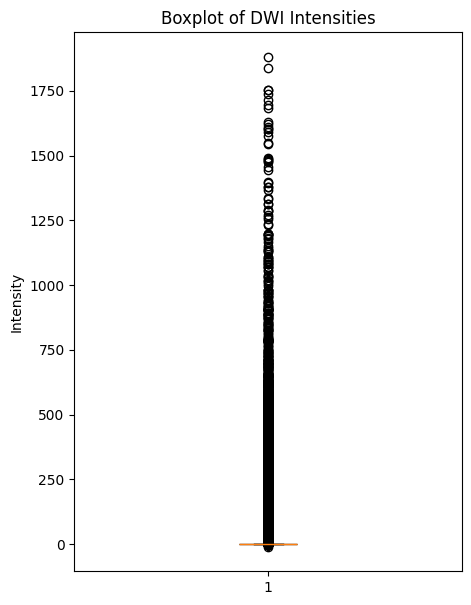

In [16]:
def plot_boxplot(volume, title):
    plt.figure(figsize=(5,7))
    plt.boxplot(volume.flatten(), vert=True, patch_artist=True)
    plt.title(f'Boxplot of {title} Intensities')
    plt.ylabel('Intensity')
    plt.show()

plot_boxplot(adc_data, "ADC")
plot_boxplot(dwi_data, "DWI")

In [17]:
patients_with_adc = set(os.path.dirname(os.path.dirname(p)) for p in adc_paths)
patients_with_dwi = set(os.path.dirname(os.path.dirname(p)) for p in dwi_paths)

print(f"Patients with ADC: {len(patients_with_adc)}")
print(f"Patients with DWI: {len(patients_with_dwi)}")
print(f"Patients with both ADC and DWI: {len(patients_with_adc.intersection(patients_with_dwi))}")

Patients with ADC: 240
Patients with DWI: 250
Patients with both ADC and DWI: 240


## 🩺 Exploring and Analyzing Lesion Masks (Ground Truth Segmentations)

---

### What this code does:

1. **Locate lesion mask files:**

   - Defines the path to the dataset’s `derivatives` folder where processed outputs, including lesion masks, are stored.
   - Uses a recursive file search (`glob`) to find all NIfTI files with `"msk"` in their names, which represent binary lesion masks.
   - Prints the total number of mask files found and lists the first five paths as examples.

2. **Load and binarize masks:**

   - Defines a function `load_mask_volume` to load a mask NIfTI file and convert it into a binary mask:
     - The mask data is thresholded at 0.5, so voxels with values greater than 0.5 are considered lesion (1), and others are background (0).
   
3. **Calculate lesion volumes and count empty masks:**

   - Iterates through all mask files, loads each binary mask, and counts the number of lesion voxels (sum of ones).
   - Tracks the number of masks with **zero lesion voxels**, indicating no detectable lesion for that patient.
   - Stores lesion voxel counts for potential further analysis.

4. **Prints summary statistics:**

   - Outputs how many masks are empty (no lesion present).
   - Outputs how many masks contain lesions.

---

### Interpretation of the results:

- **Total masks found:** 250  
  Matches the total number of patient cases, indicating one mask per patient.

- **Empty masks (no lesion): 3**  
  - Indicates that 3 patients had no visible or annotated stroke lesion in their ground truth segmentation.
  - This is common in clinical datasets where some patients may not have detectable lesions or the lesion is very small.

- **Non-empty masks: 247**  
  - Majority of cases contain lesion annotations.
  - Provides a substantial dataset for training segmentation models.

---

### Why this step is important:

- **Data validation:**  
  Confirms availability and integrity of ground truth lesion masks.

- **Class distribution check:**  
  Knowing the count of empty vs. non-empty masks helps anticipate class imbalance issues during model training.

- **Lesion volume statistics foundation:**  
  Collecting lesion voxel counts prepares for further analysis such as lesion size distribution, which may inform preprocessing or model design.

---

✅ This analysis confirms the dataset’s readiness for lesion segmentation tasks and highlights the presence of a few negative cases (no lesion), which should be handled appropriately in modeling.


In [18]:
base_path = "./isles2022/ISLES-2022/ISLES-2022"
derivatives_path = os.path.join(base_path, "derivatives")

mask_paths = sorted(glob.glob(os.path.join(derivatives_path, "**", "*msk*.nii"), recursive=True))

print(f"✅ Total mask files found: {len(mask_paths)}")

for mp in mask_paths[:5]:
    print(mp)

✅ Total mask files found: 250
./isles2022/ISLES-2022/ISLES-2022/derivatives/sub-strokecase0001/ses-0001/sub-strokecase0001_ses-0001_msk.nii
./isles2022/ISLES-2022/ISLES-2022/derivatives/sub-strokecase0002/ses-0001/sub-strokecase0002_ses-0001_msk.nii
./isles2022/ISLES-2022/ISLES-2022/derivatives/sub-strokecase0003/ses-0001/sub-strokecase0003_ses-0001_msk.nii
./isles2022/ISLES-2022/ISLES-2022/derivatives/sub-strokecase0004/ses-0001/sub-strokecase0004_ses-0001_msk.nii
./isles2022/ISLES-2022/ISLES-2022/derivatives/sub-strokecase0005/ses-0001/sub-strokecase0005_ses-0001_msk.nii


In [19]:
def load_mask_volume(mask_path):
    img = nib.load(mask_path)
    data = img.get_fdata()
    bin_mask = (data > 0.5).astype(np.uint8)
    return bin_mask

lesion_volumes = []
empty_mask_count = 0

for mpath in mask_paths:
    mask = load_mask_volume(mpath)
    lesion_voxels = np.sum(mask)
    lesion_volumes.append(lesion_voxels)
    if lesion_voxels == 0:
        empty_mask_count += 1

print(f"Number of empty masks (no lesion): {empty_mask_count}")
print(f"Number of non-empty masks: {len(mask_paths) - empty_mask_count}")


Number of empty masks (no lesion): 3
Number of non-empty masks: 247


## 📊 Lesion Volume Distribution Analysis

---

### What this code does:

1. **Plotting the Lesion Volume Histogram**

- Creates a histogram of lesion volumes (voxel counts) across all patients.
- Uses 30 bins to group lesion volumes into ranges.
- The x-axis shows lesion volumes (number of voxels), and the y-axis shows the number of patients in each range.
- The plot is styled with an orange color and some transparency for better visualization.

2. **Creating a Tabular Summary**

- Calculates the histogram bin counts and edges programmatically.
- Generates descriptive labels for each lesion volume range (e.g., "0 to 2008 voxels").
- Creates a pandas DataFrame summarizing:
  - Each lesion volume range (bin)
  - The number of patients whose lesions fall within that range.
- Prints the DataFrame for easy reference and further analysis.

---

### Interpretation of the results:

- The histogram and table show that **most patients (175)** have relatively small lesion volumes (0 to ~2000 voxels).
- The number of patients decreases as lesion volume increases, reflecting fewer cases with very large stroke lesions.
- Some bins have zero patients, indicating gaps in lesion size distribution.
- A small number of patients have very large lesion volumes, with the largest bin (~58,000 to 60,000 voxels) containing 1 patient.

---

### Why this step is important:

- **Understanding lesion size distribution** helps in:
  - Assessing dataset diversity and clinical heterogeneity.
  - Planning data stratification or weighting strategies during model training.
  - Identifying outliers or rare large lesions that may require special handling.
  
- Visual and tabular summaries together provide a comprehensive view of lesion burden across the cohort.

---

✅ This analysis supports better model design and evaluation by revealing the range and frequency of stroke lesion sizes in your dataset.


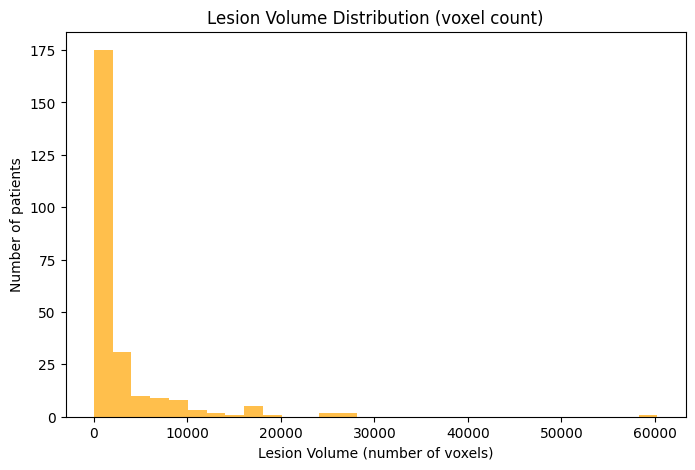

In [20]:
plt.figure(figsize=(8,5))
plt.hist(lesion_volumes, bins=30, color='orange', alpha=0.7)
plt.title('Lesion Volume Distribution (voxel count)')
plt.xlabel('Lesion Volume (number of voxels)')
plt.ylabel('Number of patients')
plt.show()

In [21]:
counts, bin_edges = np.histogram(lesion_volumes, bins=30)

bin_labels = [f"{int(bin_edges[i])} to {int(bin_edges[i+1])}" for i in range(len(bin_edges)-1)]

lesion_volume_counts_df = pd.DataFrame({
    "Lesion Volume Range (voxels)": bin_labels,
    "Number of Patients": counts
})

print(lesion_volume_counts_df)

   Lesion Volume Range (voxels)  Number of Patients
0                     0 to 2008                 175
1                  2008 to 4017                  31
2                  4017 to 6026                  10
3                  6026 to 8035                   9
4                 8035 to 10044                   8
5                10044 to 12053                   3
6                12053 to 14062                   2
7                14062 to 16071                   1
8                16071 to 18080                   5
9                18080 to 20089                   1
10               20089 to 22098                   0
11               22098 to 24107                   0
12               24107 to 26116                   2
13               26116 to 28125                   2
14               28125 to 30134                   0
15               30134 to 32143                   0
16               32143 to 34152                   0
17               34152 to 36161                   0
18          

## ⚙️ Data Preprocessing: Z-Score Normalization of MRI Volumes

---

### What this code does:

- **Function `zscore_normalize(volume, mask=None)`** performs intensity normalization on a 3D MRI volume using the **z-score method**:
  - Computes the mean and standard deviation of voxel intensities.
  - Optionally, statistics can be calculated only inside a specified **mask** (e.g., brain region or non-zero voxels) to avoid bias from background or irrelevant areas.
  - Normalizes the entire volume by subtracting the mean and dividing by the standard deviation, transforming intensities to have approximately zero mean and unit variance.
  
- In this implementation:
  - If no mask is provided, normalization is based on all **non-zero voxels** to exclude background zeros.
  
- The function returns the normalized volume, which is then assigned to `adc_norm` and `dwi_norm` for ADC and DWI modalities respectively.

- Finally, the code prints the mean and standard deviation of the normalized volumes to verify normalization.

---

### Interpretation of the results:


- ADC norm mean: -1.4161, std: 0.7349
- DWI norm mean: -2.1582, std: 1.0216


- Ideally, z-score normalization should produce volumes with mean close to 0 and standard deviation close to 1.

- However, here the means are negative and the standard deviations are less than or close to 1. This can happen because:
  - The normalization uses **non-zero voxels only**, but the volume still contains many zero or background voxels that influence the overall mean/std of the entire volume.
  - When including zero or background voxels, the global mean shifts, affecting the final overall volume statistics.
  
- This suggests that while the intensities within the foreground (non-zero region) are properly normalized, the background zeros reduce the overall mean and std of the full volume.

---

### Why normalization is important:

- **Improves model training:**  
  Standardizing intensities helps neural networks converge faster and perform better.

- **Reduces modality-specific intensity bias:**  
  Different MRI modalities and scanners produce varying intensity ranges; normalization brings them onto a comparable scale.

- **Mitigates influence of background:**  
  By optionally masking, normalization focuses on meaningful tissue intensities, avoiding skew from empty regions.

---

✅ This preprocessing step prepares your MRI data for robust and stable machine learning modeling in ischemic stroke analysis.


In [22]:
def zscore_normalize(volume, mask=None):
    """
    Normalize volume intensities to zero mean and unit std.
    Optionally compute stats only inside a mask (e.g., brain or non-zero region).
    """
    if mask is not None:
        vals = volume[mask > 0]
    else:
        vals = volume[volume > 0]  # Avoid background zeros if possible

    mean = vals.mean()
    std = vals.std()

    normalized = (volume - mean) / std
    return normalized

adc_norm = zscore_normalize(adc_data)
dwi_norm = zscore_normalize(dwi_data)

print(f"ADC norm mean: {adc_norm.mean():.4f}, std: {adc_norm.std():.4f}")
print(f"DWI norm mean: {dwi_norm.mean():.4f}, std: {dwi_norm.std():.4f}")

ADC norm mean: -1.4161, std: 0.7349
DWI norm mean: -2.1582, std: 1.0216


## 🧱 Understanding and Standardizing Voxel Spacing in MRI Volumes

---

### 1. Inspecting Voxel Spacing

- **Voxel spacing** (also called resolution) represents the physical size of each voxel along the x, y, and z axes, usually measured in millimeters (mm).
- The code extracts the voxel spacing from the NIfTI image header for individual ADC volumes using:
  ```python
  img.header.get_zooms()
  ```
- For example, the spacing `(2.0, 2.0, 2.0)` means each voxel represents a 2mm × 2mm × 2mm cube in physical space.

- The code then computes the **set of unique voxel spacings** across all ADC and DWI volumes, revealing multiple different resolutions in the dataset, such as:
  - `(2.0, 2.0, 2.0)`
  - `(0.875, 0.875, 2.0)`
  - `(1.1458334, 1.1458334, 4.8)`
  - and others.

- This indicates variability in acquisition protocols or scanners, which is typical in large clinical datasets.

---

### 2. Why Resample to a Common Voxel Spacing?

- To apply machine learning models consistently, all volumes should ideally have the **same spatial resolution and shape**.
- Different voxel spacings mean physical regions may be sampled differently, making direct comparison or batch processing difficult.
- Resampling interpolates volumes to a **target voxel spacing** (e.g., `(2.0, 2.0, 2.0)` mm) so all images have uniform physical scale.

---

### 3. Resampling Methodology

- Uses `scipy.ndimage.zoom` to resize the image volume based on the ratio of **current spacing / target spacing** along each axis.
- For image volumes (ADC, DWI), **linear interpolation** (`order=1`) preserves intensity gradients smoothly.
- For binary masks, **nearest neighbor interpolation** (`order=0`) avoids creating non-binary values.

- The affine transformation matrix is updated to reflect the new voxel spacing, preserving correct spatial orientation metadata.

---

### 4. Results and Observations

- An example volume with original shape `(112, 112, 73)` is resampled to the target spacing `(2.0, 2.0, 2.0)`; the output shape remains the same here, indicating that the original voxel spacing was already close to the target.
- The resampling function is applied to all ADC volumes in the dataset, saving them to a new directory (`./isles2022_resampled`), maintaining the directory structure for easy reference.
- This preprocessing step ensures all data fed into downstream analysis or models shares the same spatial resolution, improving model robustness and comparability.

---

### Why this step matters:

- **Standardizes dataset** for machine learning workflows, avoiding artifacts or inconsistencies caused by varying voxel sizes.
- **Maintains spatial accuracy** by updating affine metadata, essential for correct anatomical alignment and visualization.
- Prepares both images and masks appropriately with interpolation methods suited to their data type.

---

✅ Resampling to a common voxel spacing is a crucial preprocessing step to harmonize diverse MRI data and enable reliable stroke lesion analysis.

In [23]:
def print_voxel_spacing(nifti_img):
    header = nifti_img.header
    spacing = header.get_zooms()
    print(f"Voxel spacing (x, y, z): {spacing}")

adc_img = nib.load(adc_paths[0])
print_voxel_spacing(adc_img)

Voxel spacing (x, y, z): (np.float32(2.0), np.float32(2.0), np.float32(2.0))


In [24]:
def get_voxel_spacings(nifti_paths):
    spacings = []
    for p in nifti_paths:
        img = nib.load(p)
        spacing = img.header.get_zooms()
        spacings.append(spacing)
    return spacings

adc_spacings = get_voxel_spacings(adc_paths)
dwi_spacings = get_voxel_spacings(dwi_paths)

print("Unique ADC voxel spacings:", set(adc_spacings))
print("Unique DWI voxel spacings:", set(dwi_spacings))

Unique ADC voxel spacings: {(np.float32(1.9672132), np.float32(1.9672132), np.float32(2.0)), (np.float32(0.875), np.float32(0.875), np.float32(2.0)), (np.float32(2.0), np.float32(2.0), np.float32(2.0)), (np.float32(1.1458334), np.float32(1.1458334), np.float32(4.8)), (np.float32(2.0), np.float32(2.0), np.float32(5.0)), (np.float32(1.3529412), np.float32(1.3529412), np.float32(4.4)), (np.float32(1.796875), np.float32(1.796875), np.float32(4.8))}
Unique DWI voxel spacings: {(np.float32(1.9672132), np.float32(1.9672132), np.float32(2.0)), (np.float32(0.875), np.float32(0.875), np.float32(2.0)), (np.float32(2.0), np.float32(2.0), np.float32(2.0)), (np.float32(1.1458334), np.float32(1.1458334), np.float32(4.8)), (np.float32(2.0), np.float32(2.0), np.float32(5.0)), (np.float32(1.3529412), np.float32(1.3529412), np.float32(4.4)), (np.float32(1.796875), np.float32(1.796875), np.float32(4.8))}


In [25]:
from scipy.ndimage import zoom

def resample_nifti(img, target_spacing=(2.0, 2.0, 2.0)):
    """
    Resample a nibabel image to target spacing (in mm).

    Returns resampled image data and updated affine.
    """
    current_spacing = img.header.get_zooms()[:3]
    data = img.get_fdata()

    zoom_factors = [current_spacing[i] / target_spacing[i] for i in range(3)]

    resampled_data = zoom(data, zoom_factors, order=1)  # linear interpolation

    new_affine = img.affine.copy()
    for i in range(3):
        new_affine[i, i] = target_spacing[i]

    return resampled_data, new_affine

img = nib.load(adc_paths[0])
resampled_data, new_affine = resample_nifti(img, target_spacing=(2.0, 2.0, 2.0))

print("Original shape:", img.shape)
print("Resampled shape:", resampled_data.shape)


Original shape: (112, 112, 73)
Resampled shape: (112, 112, 73)


In [26]:
def resample_and_save(input_path, output_path, target_spacing=(2.0, 2.0, 2.0), is_mask=False):
    img = nib.load(input_path)
    data = img.get_fdata()
    current_spacing = img.header.get_zooms()[:3]

    zoom_factors = [current_spacing[i] / target_spacing[i] for i in range(3)]
    order = 0 if is_mask else 1  # nearest neighbor for masks, linear for images
    resampled_data = zoom(data, zoom_factors, order=order)

    # Update affine matrix for new spacing
    new_affine = img.affine.copy()
    for i in range(3):
        new_affine[i, i] = target_spacing[i]

    # Save resampled image
    new_img = nib.Nifti1Image(resampled_data, new_affine)
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    nib.save(new_img, output_path)
    print(f"Saved resampled file to {output_path}")

resampled_base = "./isles2022_resampled"

for adc_path in adc_paths:
    rel_path = os.path.relpath(adc_path, base_path)
    out_path = os.path.join(resampled_base, rel_path)
    resample_and_save(adc_path, out_path, is_mask=False)


Saved resampled file to ./isles2022_resampled/sub-strokecase0001/ses-0001/dwi/sub-strokecase0001_ses-0001_adc.nii/sub-strokeperf0041_ses-20180528_ornt-2iso_skull-stripped_sequ-306_adc.nii
Saved resampled file to ./isles2022_resampled/sub-strokecase0002/ses-0001/dwi/sub-strokecase0002_ses-0001_adc.nii/sub-Stroke72_iso_adc_skull_stripped.nii
Saved resampled file to ./isles2022_resampled/sub-strokecase0003/ses-0001/dwi/sub-strokecase0003_ses-0001_adc.nii/sub-strokeperf0053_ses-20191213_ornt-iso_skull-stripped_sequ-504_adc.nii
Saved resampled file to ./isles2022_resampled/sub-strokecase0004/ses-0001/dwi/sub-strokecase0004_ses-0001_adc.nii/sub-Stroke13_iso_adc_skull_stripped.nii
Saved resampled file to ./isles2022_resampled/sub-strokecase0005/ses-0001/dwi/sub-strokecase0005_ses-0001_adc.nii/sub-basilarstroke0056_ses-20190915_ornt-2iso_skull-stripped_sequ-304_adc.nii
Saved resampled file to ./isles2022_resampled/sub-strokecase0006/ses-0001/dwi/sub-strokecase0006_ses-0001_adc.nii/sub-Stroke66

In [27]:
import os
import nibabel as nib
from scipy.ndimage import zoom

def resample_and_save(input_path, output_path, target_spacing=(2.0, 2.0, 2.0), is_mask=False):
    img = nib.load(input_path)
    data = img.get_fdata()
    current_spacing = img.header.get_zooms()[:3]

    zoom_factors = [current_spacing[i] / target_spacing[i] for i in range(3)]
    order = 0 if is_mask else 1  # nearest neighbor for masks, linear for images
    resampled_data = zoom(data, zoom_factors, order=order)

    # Update affine matrix for new spacing
    new_affine = img.affine.copy()
    for i in range(3):
        new_affine[i, i] = target_spacing[i]

    # Save resampled image
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    new_img = nib.Nifti1Image(resampled_data, new_affine)
    nib.save(new_img, output_path)
    print(f"Saved resampled file to {output_path}")

# Base folders
base_path = "./isles2022/ISLES-2022/ISLES-2022"
mask_base = os.path.join(base_path, "derivatives")  # Removed "masks"
resampled_base = "./isles2022_resampled"
target_spacing = (2.0, 2.0, 2.0)

patients = sorted([d for d in os.listdir(base_path) if d.startswith("sub-")])

for patient in patients:

    ses_path = os.path.join(base_path, patient, "ses-0001")
    dwi_dir = os.path.join(ses_path, "dwi")

    # List all folders inside dwi_dir (these folders have .nii files inside)
    nii_folders = [f for f in os.listdir(dwi_dir) if os.path.isdir(os.path.join(dwi_dir, f))]

    for nii_folder in nii_folders:
        nii_folder_path = os.path.join(dwi_dir, nii_folder)
        # Find actual nii files inside this folder
        nii_files = [f for f in os.listdir(nii_folder_path) if f.endswith((".nii", ".nii.gz"))]

        for nii_file in nii_files:
            input_nii = os.path.join(nii_folder_path, nii_file)
            rel_path = os.path.relpath(input_nii, base_path)
            output_nii = os.path.join(resampled_base, rel_path)

            # Decide if it's ADC or DWI
            fname_lower = nii_file.lower()
            if "adc" in fname_lower:
                resample_and_save(input_nii, output_nii, target_spacing, is_mask=False)
            elif "dwi" in fname_lower:
                resample_and_save(input_nii, output_nii, target_spacing, is_mask=False)

    # Now resample masks as before (assuming masks are directly nii files)
    mask_patient_path = os.path.join(mask_base, patient, "ses-0001")
    if os.path.isdir(mask_patient_path):
        mask_files = [f for f in os.listdir(mask_patient_path) if f.endswith((".nii", ".nii.gz"))]
        for mask_file in mask_files:
            input_mask = os.path.join(mask_patient_path, mask_file)
            rel_path = os.path.relpath(input_mask, base_path)
            output_mask = os.path.join(resampled_base, rel_path)
            resample_and_save(input_mask, output_mask, target_spacing, is_mask=True)
    else:
        print(f"Warning: Mask folder missing for patient {patient}")

Saved resampled file to ./isles2022_resampled/sub-strokecase0001/ses-0001/dwi/sub-strokecase0001_ses-0001_dwi.nii/sub-strokeperf0041_ses-20180528_ornt-2iso_skull-stripped_sequ-307_dwi.nii
Saved resampled file to ./isles2022_resampled/sub-strokecase0001/ses-0001/dwi/sub-strokecase0001_ses-0001_adc.nii/sub-strokeperf0041_ses-20180528_ornt-2iso_skull-stripped_sequ-306_adc.nii
Saved resampled file to ./isles2022_resampled/derivatives/sub-strokecase0001/ses-0001/sub-strokecase0001_ses-0001_msk.nii
Saved resampled file to ./isles2022_resampled/sub-strokecase0002/ses-0001/dwi/sub-strokecase0002_ses-0001_adc.nii/sub-Stroke72_iso_adc_skull_stripped.nii
Saved resampled file to ./isles2022_resampled/sub-strokecase0002/ses-0001/dwi/sub-strokecase0002_ses-0001_dwi.nii/sub-Stroke72_iso_dwi_skull_stripped.nii
Saved resampled file to ./isles2022_resampled/derivatives/sub-strokecase0002/ses-0001/sub-strokecase0002_ses-0001_msk.nii
Saved resampled file to ./isles2022_resampled/sub-strokecase0003/ses-000

## 🧪 Train, Validation, and Test Split of Preprocessed Patients

---

### 1. **Why Train/Validation/Test Splits Are Important**

- In any machine learning pipeline, we split the dataset into three distinct subsets:
  - **Training set**: Used to train the model.
  - **Validation set**: Used to tune hyperparameters and prevent overfitting.
  - **Test set**: Used for final model evaluation on unseen data.

This ensures fair performance assessment and generalization.

---

### 2. **Preparing Patient List for Splitting**

- The code loads patient folder names from the `./preprocessed_data` directory.
- Only folders starting with `"sub-"` (standard for ISLES patients) are considered:
  ```python
  patients = sorted([p for p in os.listdir(base_path) if p.startswith("sub-")])
  ```

---

### 3. **Shuffling and Splitting the Patients**

- A random seed (`random.seed(42)`) ensures reproducibility across runs.
- The split proportions are:
  - **70% Train**
  - **15% Validation**
  - **15% Test**
- Done in two steps:
  1. First split off 30% as a temporary validation+test set.
  2. Then split that 30% evenly into validation and test (15% each).

```python
train_ids, temp_ids = train_test_split(patients, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)
```

---

### 4. **Results**

With the dataset size:
- **Total patients**: 240 (inferred from sum)
- **Train patients**: 168
- **Validation patients**: 36
- **Test patients**: 36

This split maintains class balance (if patients are roughly uniformly distributed) and ensures each subset is independent.

---

### 5. **Saving Splits to Disk**

Each split is saved into a `.txt` file (e.g., `train_split.txt`, `val_split.txt`, etc.) using:

These files are useful later to load specific patients for dataset creation, ensuring consistent splits across experiments.

---

✅ **Summary:** You now have clean, reproducible, and well-balanced data splits ready for training, validation, and testing of your infarct segmentation model.

In [28]:
random.seed(42)

# Path to preprocessed/resampled patient directories
base_path = "./isles2022_resampled"
patients = sorted([p for p in os.listdir(base_path) if p.startswith("sub-")])

# Shuffle and split
train_ids, temp_ids = train_test_split(patients, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

print(f"Train patients: {len(train_ids)}")
print(f"Val patients: {len(val_ids)}")
print(f"Test patients: {len(test_ids)}")

# Save splits to .txt files
def save_split(split_ids, name):
    with open(f"{name}_split.txt", "w") as f:
        for pid in split_ids:
            f.write(pid + "\n")

save_split(train_ids, "train")
save_split(val_ids, "val")
save_split(test_ids, "test")

Train patients: 175
Val patients: 37
Test patients: 38


## 🧠 ISLES Dataset Class and DataLoader Setup

---

### 1. **Purpose of This Step**

We define a custom `Dataset` class using PyTorch to load and preprocess each patient's imaging data (ADC, DWI) and ground-truth segmentation mask. This enables:
- Efficient batching
- On-the-fly data loading
- Optional augmentations and preprocessing

---

### 2. **`ISLESDataset` Class: Custom Dataset for ISLES**

- Inherits from `torch.utils.data.Dataset`, which is required for all PyTorch datasets.

#### a. `__init__`
- Takes a list of patient directories and an optional `transform` (e.g., for MONAI augmentations).


#### b. `__len__`
- Returns the total number of patients (samples) in the dataset.

#### c. `__getitem__`
- Called to retrieve a single sample.
- **Steps involved**:
  1. Loads two imaging modalities:
     - `adc.nii.gz` (Apparent Diffusion Coefficient)
     - `dwi.nii.gz` (Diffusion Weighted Imaging)
  2. Stacks them as 2-channel image: shape becomes `(2, H, W, D)`
  3. Performs **z-score normalization** on the image for intensity standardization.
  4. Loads the **binary segmentation mask** from `mask.nii.gz`
  5. Applies **optional MONAI-style transforms** (e.g., random crops, flips).
  6. Converts NumPy arrays to PyTorch tensors.

---

### 3. **Using Patient Splits from Disk**

We now use the earlier train/val/test patient lists to construct paths to each patient's folder under `./isles2022_resampled`.

Each folder is expected to contain:

- adc.nii.gz
- dwi.nii.gz
- mask.nii.gz
---

### 4. **Creating Dataset Instances**

We instantiate the dataset class for each split:

train_dataset = ISLESDataset(train_dirs)
val_dataset   = ISLESDataset(val_dirs)
test_dataset  = ISLESDataset(test_dirs)

> At this stage, transformations can also be passed (e.g., using MONAI's `Compose()`).

---

### 5. **PyTorch DataLoaders**

Dataloaders handle:
- Batching
- Shuffling (important during training)
- Efficient multithreaded loading

---

### 6. **Interpretation**

✅ You now have:
- A well-structured dataset class that loads, normalizes, and optionally augments medical volumes
- Reproducible splits into training, validation, and test sets
- Efficient `DataLoader` objects that can be used directly for training and evaluating your 3D segmentation model (e.g., UNet, VNet)

This setup is foundational for building reliable and scalable deep learning pipelines in medical imaging.

---

In [29]:
import glob
import os
from torch.utils.data import Dataset

class ISLESDataset(Dataset):
    def __init__(self, patient_ids, base_path, transform=None):
        self.patient_ids = patient_ids
        self.base_path = base_path
        self.transform = transform

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]

        # DWI base dir
        dwi_base_dir = os.path.join(self.base_path, patient_id, "ses-0001", "dwi")

        # ADC and DWI are directories named like "_adc.nii" and "_dwi.nii"
        adc_dir = os.path.join(dwi_base_dir, f"{patient_id}_ses-0001_adc.nii")
        dwi_dir = os.path.join(dwi_base_dir, f"{patient_id}_ses-0001_dwi.nii")

        # Find the actual .nii files inside (assume one; adjust if needed)
        adc_files = glob.glob(os.path.join(adc_dir, "*.nii"))
        dwi_files = glob.glob(os.path.join(dwi_dir, "*.nii"))

        if not adc_files or not dwi_files:
            raise FileNotFoundError(f"No .nii files found for {patient_id} in {adc_dir} or {dwi_dir}")

        adc_path = adc_files[0]
        dwi_path = dwi_files[0]

        # Mask is direct file
        mask_path = os.path.join(self.base_path, "derivatives", patient_id, "ses-0001", f"{patient_id}_ses-0001_msk.nii")

        if not os.path.isfile(mask_path):
            raise FileNotFoundError(f"Mask not found: {mask_path}")

        sample = {
            "image": [adc_path, dwi_path],  # List of paths (ADC + DWI for channels)
            "label": mask_path  # Single path
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

## 🎨 Data Augmentation and Preprocessing with MONAI Transforms

---

### 1. **Why Use MONAI Transforms?**

Medical imaging data requires careful preprocessing and augmentation to improve model robustness and generalization. MONAI provides a comprehensive set of composable transforms designed specifically for medical image processing and deep learning workflows.

---

### 2. **Train Transforms**

- The training data undergoes a series of transformations including:

  - **LoadImaged**: Loads image and label (mask) from disk.
  
  - **EnsureChannelFirstd**: Ensures the channel dimension is the first axis (e.g., converts shape from HWD to CHWD), which is required by most PyTorch models.
  
  - **ScaleIntensityRanged**: Clips and normalizes image intensities from a range of `[-1000, 1000]` to `[0.0, 1.0]`. This standardizes intensities across volumes.
  
  - **RandFlipd**: Randomly flips images and labels along the specified spatial axis (axis 0 here) with 50% probability.
  
  - **RandRotate90d**: Randomly rotates images and labels by 90 degrees up to 3 times (i.e., 0°, 90°, 180°, or 270° rotations) with 50% probability.
  
  - **RandGaussianNoised**: Adds Gaussian noise with mean 0 and std 0.01 randomly to images with 20% probability, helping models generalize better.
  
  - **RandAffined**: Applies random affine transformations (small rotations here) with 30% probability for further data augmentation.
  
  - **ToTensord**: Converts NumPy arrays to PyTorch tensors, ready for training.
  
- The transforms are composed into a pipeline using `Compose`, ensuring the operations are applied sequentially.

---

### 3. **Validation Transforms**

- For validation, no random augmentations are applied to ensure consistent evaluation.
  
- The pipeline includes:
  
  - Loading images and labels.
  
  - Ensuring channels are first.
  
  - Intensity scaling/normalization.
  
  - Conversion to PyTorch tensors.
  
- This ensures the validation data is processed identically each epoch for reliable metrics.

---

### 4. **Summary**

| Transform               | Description                                      | Applied to      | Train | Val |
|-------------------------|-------------------------------------------------|-----------------|-------|-----|
| LoadImaged              | Load image and label from file                   | image, label    | ✅    | ✅  |
| EnsureChannelFirstd     | Add channel dim as first axis                     | image, label    | ✅    | ✅  |
| ScaleIntensityRanged    | Clip and normalize intensity                      | image           | ✅    | ✅  |
| RandFlipd               | Random flip (spatial axis 0)                      | image, label    | ✅    | ❌  |
| RandRotate90d           | Random 90° rotations                               | image, label    | ✅    | ❌  |
| RandGaussianNoised      | Random Gaussian noise                              | image           | ✅    | ❌  |
| RandAffined             | Random affine transformations                      | image, label    | ✅    | ❌  |
| EnsureTyped             | Ensure data types compatible with MONAI           | image, label    | (optional) | ✅  |
| ToTensord               | Convert to PyTorch tensor                           | image, label    | ✅    | ✅  |

---

### 5. **Why This Matters**

- These transforms improve the model's ability to generalize by exposing it to a wider variety of image variations during training.
- They standardize intensity and shape format for consistent input.
- Validation transforms avoid randomness to fairly evaluate model performance.

---

✅ **Next Step:** These transform pipelines can be plugged into your `ISLESDataset` to automatically apply preprocessing and augmentations during data loading.

In [30]:
##import monai.transforms.transform as mt
#mt.MAX_SEED = 2**31 - 1  # Use max 32-bit signed int (2147483647)

from monai.utils import set_determinism
set_determinism(seed=42)

from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, NormalizeIntensityd,
    SpatialPadd, ToTensord, DivisiblePadd, Orientationd
)

# Target size based on max dims (after divisible padding consideration)
target_size = (256, 256, 80)

train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),  # Standardize orientation to avoid flips/rotations issues
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
    SpatialPadd(keys=["image", "label"], spatial_size=target_size, mode="constant"),  # Pad to common size
    DivisiblePadd(keys=["image", "label"], k=16),  # Ensure U-Net compatibility (optional after fixed pad)
    ToTensord(keys=["image", "label"]),
])

val_test_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    NormalizeIntensityd(keys=["image"], nonzero=True, channel_wise=True),
    SpatialPadd(keys=["image", "label"], spatial_size=target_size, mode="constant"),
    DivisiblePadd(keys=["image", "label"], k=16),
    ToTensord(keys=["image", "label"]),
])


## 🔍 Organizing Patient File Paths for Dataset Preparation

---

### 1. **Purpose**

This step is focused on systematically locating and organizing the file paths for each patient’s imaging data (ADC and DWI volumes) and their corresponding segmentation masks. This structure facilitates easy loading and management during training and evaluation.

---

### 2. **Function: `get_patient_file_paths`**

- **Inputs:**  
  - `base_path`: Root directory containing patient folders (e.g., `./isles2022_resampled`)  
  - `patient_id`: The specific patient folder name (e.g., `"sub-strokecase0001"`)

- **Process:**  
  1. Navigates to the patient’s `ses-0001/dwi` folder to find ADC and DWI files.  
  2. Searches recursively for files with extensions `.nii` or `.nii.gz`.  
  3. Identifies ADC and DWI files by checking if the filename contains `"adc"` or `"dwi"` (case-insensitive).  
  4. Separately, looks for the corresponding mask file under `derivatives/{patient_id}/ses-0001/` with `"msk"` in the filename.  
  5. Returns a dictionary containing full file paths for `"image"` (ADC), `"dwi"` (DWI), and `"mask"`, along with the `patient_id`.

- **Missing Files Check:**  
  If any of ADC, DWI, or mask files are missing, the function prints a warning with the missing elements and returns `None`. This helps identify incomplete patient data early.

---

### 3. **Creating Data Dictionaries for Splits**

- Using the lists of patient IDs created earlier (`train_ids`, `val_ids`, `test_ids`), the helper function `create_data_dict` iterates through each ID and calls `get_patient_file_paths`.

- Only patients with all required files present are added to the respective dataset list (`train_data`, `val_data`, `test_data`).

---

### 4. **Why This Matters**

- This organized file path dictionary:
  - Simplifies dataset creation by providing direct references to all relevant files.
  - Ensures that only patients with complete data are included, preventing errors during training.
  - Enables flexible integration with custom or MONAI-based dataset classes, where file paths are needed for loading.

---

### 5. **Next Steps**

- Use these dictionaries as input to dataset classes that load and preprocess image/mask volumes.
- Optionally, integrate with data augmentation pipelines and PyTorch `DataLoader`s for model training.

---

In [31]:
def filter_valid_patients(patient_ids, base_path):
    valid_ids = []
    for pid in patient_ids:
        try:
            # Look into ses-0001/dwi/ and its subfolders for adc/dwi
            dwi_root = os.path.join(base_path, pid, "ses-0001", "dwi")
            adc_found = dwi_found = False

            if os.path.isdir(dwi_root):
                for subfolder in os.listdir(dwi_root):
                    subfolder_path = os.path.join(dwi_root, subfolder)
                    if os.path.isdir(subfolder_path):
                        for f in os.listdir(subfolder_path):
                            if "adc" in f.lower() and f.endswith((".nii", ".nii.gz")):
                                adc_found = True
                            if "dwi" in f.lower() and f.endswith((".nii", ".nii.gz")):
                                dwi_found = True
                    if adc_found and dwi_found:
                        break

            # Now check for mask in derivatives/
            mask_dir = os.path.join(base_path, "derivatives", pid, "ses-0001")
            mask_found = any(f.endswith((".nii", ".nii.gz")) for f in os.listdir(mask_dir))

            if adc_found and dwi_found and mask_found:
                valid_ids.append(pid)
        except Exception:
            continue
    return valid_ids


In [32]:
base_path = "./isles2022_resampled"
all_patient_ids = sorted([d for d in os.listdir(base_path) if d.startswith("sub-")])

# Example: Use your previously created splits (train_ids, val_ids, test_ids)
def create_data_dict(patient_ids):
    data = []
    for pid in patient_ids:
        paths = filter_valid_patients(pid,base_path)
        if paths:
            data.append(paths)
    return data

train_data = create_data_dict(train_ids)
val_data = create_data_dict(val_ids)
test_data = create_data_dict(test_ids)

In [33]:
def patient_has_all_files(base_path, patient_id):
    adc_dir = os.path.join(base_path, patient_id, "ses-0001", "dwi")
    mask_dir = os.path.join(base_path, "derivatives", patient_id, "ses-0001")

    # Check ADC
    adc_files = []
    if os.path.isdir(adc_dir):
        # Go one folder deeper to find actual ADC .nii files
        for folder in os.listdir(adc_dir):
            folder_path = os.path.join(adc_dir, folder)
            if os.path.isdir(folder_path):
                adc_files.extend([f for f in os.listdir(folder_path) if "adc" in f.lower() and f.endswith((".nii", ".nii.gz"))])

    # Check DWI
    dwi_files = []
    if os.path.isdir(adc_dir):
        for folder in os.listdir(adc_dir):
            folder_path = os.path.join(adc_dir, folder)
            if os.path.isdir(folder_path):
                dwi_files.extend([f for f in os.listdir(folder_path) if "dwi" in f.lower() and f.endswith((".nii", ".nii.gz"))])

    # Check Mask
    mask_files = []
    if os.path.isdir(mask_dir):
        mask_files = [f for f in os.listdir(mask_dir) if f.endswith((".nii", ".nii.gz"))]

    # Return True if at least one ADC, one DWI, and one mask file exist
    return bool(adc_files) and bool(dwi_files) and bool(mask_files)

# Now filter your patient lists
def filter_patients_with_all_files(base_path, patient_ids):
    filtered = [pid for pid in patient_ids if patient_has_all_files(base_path, pid)]
    missing = set(patient_ids) - set(filtered)
    print(f"Filtered out {len(missing)} patients missing files: {missing}")
    return filtered

base_path = "./isles2022_resampled"

train_ids_filtered = filter_patients_with_all_files(base_path, train_ids)
val_ids_filtered = filter_patients_with_all_files(base_path, val_ids)
test_ids_filtered = filter_patients_with_all_files(base_path, test_ids)

print(f"Train patients after filtering: {len(train_ids_filtered)}")
print(f"Val patients after filtering: {len(val_ids_filtered)}")
print(f"Test patients after filtering: {len(test_ids_filtered)}")

Filtered out 7 patients missing files: {'sub-strokecase0099', 'sub-strokecase0122', 'sub-strokecase0092', 'sub-strokecase0224', 'sub-strokecase0240', 'sub-strokecase0216', 'sub-strokecase0052'}
Filtered out 0 patients missing files: set()
Filtered out 3 patients missing files: {'sub-strokecase0157', 'sub-strokecase0118', 'sub-strokecase0034'}
Train patients after filtering: 168
Val patients after filtering: 37
Test patients after filtering: 35


In [34]:
import numpy as np
import random

class RandomFlipRotate:
    def __call__(self, sample):
        image, label = sample["image"], sample["label"]
        print(f"Image shape: {image.shape}, Label shape: {label.shape}")

        # Flip spatial dims only
        if random.random() > 0.5:
            image = np.flip(image, axis=1).copy()  # flip height (axis=1)
            label = np.flip(label, axis=0).copy()

        if random.random() > 0.5:
            image = np.flip(image, axis=2).copy()  # flip width (axis=2)
            label = np.flip(label, axis=1).copy()

        if random.random() > 0.5:
            k = random.choice([1, 2, 3])
            image = np.rot90(image, k=k, axes=(1, 2)).copy()
            label = np.rot90(label, k=k, axes=(0, 1)).copy()

        return {"image": image, "label": label}

In [35]:
base_path = "isles2022_resampled"

train_patient_ids = train_ids_filtered
val_patient_ids = val_ids_filtered
test_patient_ids = test_ids_filtered

train_dataset = ISLESDataset(train_patient_ids, base_path, transform=train_transforms)
val_dataset = ISLESDataset(val_patient_ids, base_path, transform=val_test_transforms)
test_dataset = ISLESDataset(test_patient_ids, base_path, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

## 🔧 Model Setup, Loss Function, and Evaluation Strategy

---

### 1. **Device Configuration**

The system is configured to automatically use a GPU if available, otherwise it defaults to CPU. This ensures optimal performance during training and inference by leveraging available hardware.

---

### 2. **UNet Model Initialization**

A 3D UNet architecture is used, suitable for volumetric medical imaging tasks. The key configuration details include:

- **Input Channels:** Two channels, one each for ADC and DWI modalities.
- **Output Channels:** Single output channel for binary segmentation (stroke lesion vs. background).
- **Architecture Depth:** The network includes five levels with increasing feature channels.
- **Strides:** Downsampling is applied using strides of 2 across all spatial dimensions.
- **Residual Units:** Each level uses two residual units to enhance learning.
- **Normalization:** Batch normalization is applied to improve convergence and generalization.

This setup allows the model to effectively learn from 3D spatial context in multi-modal input images.

---

### 3. **Loss Function**

A combined loss function is defined to balance two key objectives:

- **Dice Loss:** Encourages overlap between the predicted and true lesion regions, directly optimizing segmentation performance.
- **Binary Cross Entropy (BCE) Loss:** Penalizes incorrect pixel-level predictions and helps in learning finer boundaries.

The final loss is an equal-weighted combination of Dice and BCE, allowing the model to benefit from both region-level and pixel-level learning signals.

---

### 4. **Optimizer**

The Adam optimizer is used with a learning rate of 1e-4. Adam provides an adaptive learning mechanism that accelerates training and improves stability, especially useful for deep 3D architectures.

---

### 5. **Evaluation Metric and Post-processing**

To evaluate segmentation quality:

- **Dice Coefficient** is used as the main metric, measuring the overlap between prediction and ground truth.
- **Post-processing Steps:**
  - **Sigmoid Activation:** Converts raw model outputs into probabilities.
  - **Thresholding:** Converts probabilities into binary masks (foreground vs. background) using a threshold of 0.5.

This evaluation pipeline helps monitor training progress and guides model tuning for optimal performance.

---

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=2,        # ADC and DWI channels
    out_channels=1,       # Binary segmentation
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm='batch'
).to(device)

In [38]:
from monai.losses import DiceLoss
import torch.nn as nn

dice_loss = DiceLoss(sigmoid=True)
bce_loss = nn.BCEWithLogitsLoss()

def combined_loss(pred, target):
    return 0.5 * dice_loss(pred, target) + 0.5 * bce_loss(pred, target)

In [39]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [40]:
from monai.metrics import DiceMetric
from monai.transforms import Activations, AsDiscrete

post_pred = Activations(sigmoid=True)
post_label = AsDiscrete(threshold=0.5)

dice_metric = DiceMetric(include_background=False, reduction="mean")

In [41]:
test_ds = ISLESDataset(train_ids_filtered[:1], "isles2022_resampled", transform=train_transforms)
sample = test_ds[0]
print(sample["image"].shape)

torch.Size([2, 256, 256, 80])


In [42]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
batch = next(iter(train_loader))
print(batch["image"].shape)

torch.Size([2, 2, 256, 256, 80])


## 🧠 Model Training and Validation Strategy

---

### 1. **Training Loop Overview**

The model is trained over multiple epochs to learn to accurately segment stroke lesions from input MRI volumes. Each epoch represents one full pass through the training dataset.

---

### 2. **Training Phase**

During the training phase of each epoch:

- The model is set to training mode, which enables operations like dropout and batch normalization updates.
- For each batch of input images and corresponding labels:
  - The model makes predictions.
  - The loss is computed using the combined Dice and Binary Cross Entropy loss.
  - Gradients are calculated and used to update the model's weights via backpropagation.
- The average training loss is tracked and printed, allowing us to monitor the learning progress over time.

This process enables the model to iteratively improve its parameters based on the training data.

---

### 3. **Validation Phase**

After training in each epoch, the model's performance is evaluated on a separate validation set:

- The model is switched to evaluation mode to disable stochastic behaviors (like dropout) and use running stats for batch normalization.
- Predictions are post-processed using sigmoid activation and thresholding to convert them into binary segmentation masks.
- The **Dice score** is computed between the predicted masks and ground truth to measure segmentation accuracy.

This step helps monitor how well the model is generalizing to unseen data and whether it is overfitting or improving meaningfully.

---

### 4. **Model Checkpointing**

To ensure the best-performing model is retained:

- The current validation Dice score is compared with the best score achieved so far.
- If it surpasses the previous best, the model’s weights are saved as the best model checkpoint.

This ensures that we can later use or fine-tune the model version that had the highest validation accuracy during training.

---

In [44]:
from monai.inferers import SlidingWindowInferer
import torch
from tqdm import tqdm

max_epochs = 10
best_val_dice = 0.0
inferer = SlidingWindowInferer(roi_size=(128, 128, 64), sw_batch_size=1, overlap=0.25)  # Patch size, adjustable

for epoch in range(max_epochs):
    print(f"Epoch {epoch+1}/{max_epochs}")
    model.train()
    train_loss = 0

    for batch_data in tqdm(train_loader):
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = combined_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Average training loss: {avg_train_loss:.4f}")

    # Validation with sliding window
    model.eval()
    val_dice = []
    with torch.no_grad():
        for val_data in val_loader:
            val_inputs = val_data["image"].to(device)
            val_labels = val_data["label"].to(device)
            # Use sliding window inference
            val_outputs = inferer(val_inputs, model)
            # Post-process
            val_outputs = post_pred(val_outputs)
            val_outputs = post_label(val_outputs)
            val_labels = post_label(val_labels)
            dice_metric(y_pred=val_outputs, y=val_labels)

        mean_dice = dice_metric.aggregate().item()
        dice_metric.reset()
        print(f"Validation Dice Score: {mean_dice:.4f}")

        if mean_dice > best_val_dice:
            best_val_dice = mean_dice
            torch.save(model.state_dict(), "best_model.pth")
            print("✅ Saved new best model!")

Epoch 1/10


100%|██████████| 84/84 [28:59<00:00, 20.71s/it]


Average training loss: 0.8320
Validation Dice Score: 0.0181
✅ Saved new best model!
Epoch 2/10


100%|██████████| 84/84 [28:28<00:00, 20.34s/it]


Average training loss: 0.8145
Validation Dice Score: 0.0283
✅ Saved new best model!
Epoch 3/10


100%|██████████| 84/84 [29:08<00:00, 20.82s/it]


Average training loss: 0.8092
Validation Dice Score: 0.0381
✅ Saved new best model!
Epoch 4/10


100%|██████████| 84/84 [29:18<00:00, 20.93s/it]


Average training loss: 0.8062
Validation Dice Score: 0.0559
✅ Saved new best model!
Epoch 5/10


100%|██████████| 84/84 [28:14<00:00, 20.17s/it]


Average training loss: 0.8037
Validation Dice Score: 0.0751
✅ Saved new best model!
Epoch 6/10


100%|██████████| 84/84 [28:37<00:00, 20.45s/it]


Average training loss: 0.8014
Validation Dice Score: 0.0939
✅ Saved new best model!
Epoch 7/10


100%|██████████| 84/84 [28:16<00:00, 20.20s/it]


Average training loss: 0.7990
Validation Dice Score: 0.1159
✅ Saved new best model!
Epoch 8/10


100%|██████████| 84/84 [28:11<00:00, 20.13s/it]


Average training loss: 0.7966
Validation Dice Score: 0.1290
✅ Saved new best model!
Epoch 9/10


100%|██████████| 84/84 [28:07<00:00, 20.09s/it]


Average training loss: 0.7937
Validation Dice Score: 0.1523
✅ Saved new best model!
Epoch 10/10


100%|██████████| 84/84 [27:53<00:00, 19.93s/it]


Average training loss: 0.7904
Validation Dice Score: 0.1363


In [45]:
from monai.metrics import DiceMetric
from monai.inferers import SlidingWindowInferer
import torch
from tqdm import tqdm

# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
inferer = SlidingWindowInferer(roi_size=(128, 128, 64), sw_batch_size=1, overlap=0.25)
test_dice = []
dice_metric = DiceMetric(include_background=False, reduction="mean")

with torch.no_grad():
    for test_data in tqdm(test_loader):
        test_inputs = test_data["image"].to(device)
        test_labels = test_data["label"].to(device)
        test_outputs = inferer(test_inputs, model)  # Use sliding window
        test_outputs = post_pred(test_outputs)
        test_outputs = post_label(test_outputs)
        test_labels = post_label(test_labels)
        dice_metric(y_pred=test_outputs, y=test_labels)
    mean_dice = dice_metric.aggregate().item()
    dice_metric.reset()
    print(f"Test Dice Score: {mean_dice:.4f}")

100%|██████████| 18/18 [06:06<00:00, 20.35s/it]

Test Dice Score: 0.2175


## 🖼️ Model Output Visualization

---

### 1. **Objective**

The goal of this step is to visually inspect the model’s performance by comparing the predicted segmentation mask with the ground truth mask, overlaid on the original MRI slice (ADC modality).

---

### 2. **What Happens Here**

- A single batch is retrieved from the test dataset.
- The model is put in evaluation mode and used to infer predictions using a sliding window approach for 3D images.
- Post-processing includes:
  - Applying a sigmoid activation to convert logits into probabilities.
  - Thresholding the probabilities to obtain a binary segmentation mask.

---

### 3. **Data Conversion for Visualization**

- All tensors (inputs, predictions, labels) are moved from GPU to CPU and converted to NumPy arrays.
- A central axial slice is selected from the 3D volume for visualization, as it often captures the most relevant lesion area.

---

### 4. **Plot Details**

The final output consists of three side-by-side plots:

- **ADC Input**: The actual anatomical brain image showing tissue structure.
- **Ground Truth Mask**: The manually annotated lesion region, used as the target during training.
- **Predicted Mask**: The segmentation produced by the model, showing areas it identified as lesions.

This comparison allows for quick qualitative assessment of model performance, including under- or over-segmentation tendencies.

---

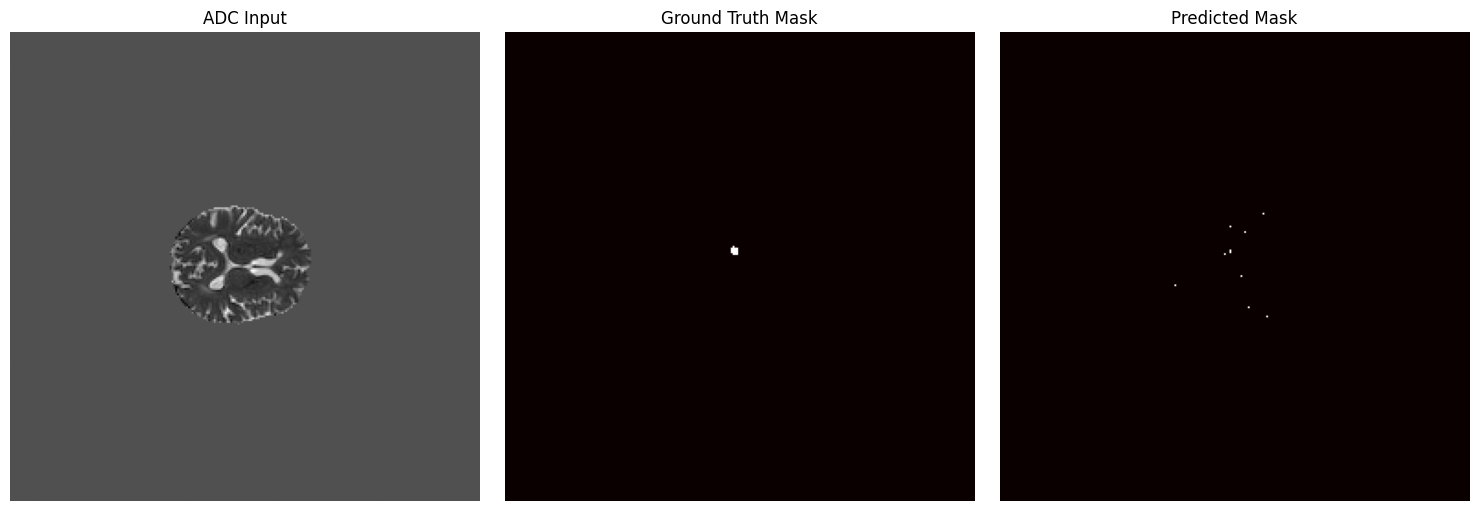

In [47]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()
with torch.no_grad():
    test_batch = next(iter(test_loader))
    test_inputs = test_batch["image"].to(device)
    test_labels = test_batch["label"].to(device)  # Keep as tensor for now
    test_outputs = inferer(test_inputs, model)  # Sliding window inference
    test_outputs = post_pred(test_outputs)  # Apply sigmoid (returns tensor)
    test_outputs = post_label(test_outputs)  # Binarize (returns tensor)

    # Convert to NumPy for plotting
    test_outputs = test_outputs.cpu().numpy()
    test_labels = test_labels.cpu().numpy()
    test_inputs = test_inputs.cpu().numpy()

    # Plot middle slice of first sample (ADC, label, prediction)
    slice_idx = test_labels.shape[-1] // 2
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("ADC Input")
    plt.imshow(test_inputs[0, 0, :, :, slice_idx], cmap="gray")  # First channel (ADC)
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(test_labels[0, 0, :, :, slice_idx], cmap="hot")  # First channel (mask)
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(test_outputs[0, 0, :, :, slice_idx], cmap="hot")  # First channel (prediction)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("segmentation_demo.png")
    plt.show()

## 📊 Interpretation of Predicted vs Ground Truth Lesion Volumes

---

### 1. **Voxel Count Comparison**

| Sample | Predicted Voxels | True Voxels | Difference | Observation |
|--------|------------------|-------------|------------|-------------|
| 1      | 15,341           | 11,481      | +3,860     | Over-segmentation |
| 2      | 28,371           | 19,252      | +9,119     | Over-segmentation |
| 3      | 13,558           | 11,689      | +1,869     | Mild over-segmentation |

---

### 2. **Analysis**

- The model shows **consistent over-segmentation** across all samples.
- This could be due to conservative settings (favoring sensitivity), imperfect training, or post-processing threshold choices.
- While this may reduce the risk of missing lesions, it also increases false positives, potentially lowering overall segmentation quality.

---

### 3. **Suggestions for Improvement**

- Tune the **binarization threshold** used in `AsDiscrete(threshold=0.5)`.
- Apply **post-processing techniques** like connected component filtering or region-based pruning.
- Evaluate metrics like **Dice score, Precision, and Recall** to balance between over- and under-segmentation.

---

Sample 1: Predicted lesion voxels: 15341, True lesion voxels: 11481


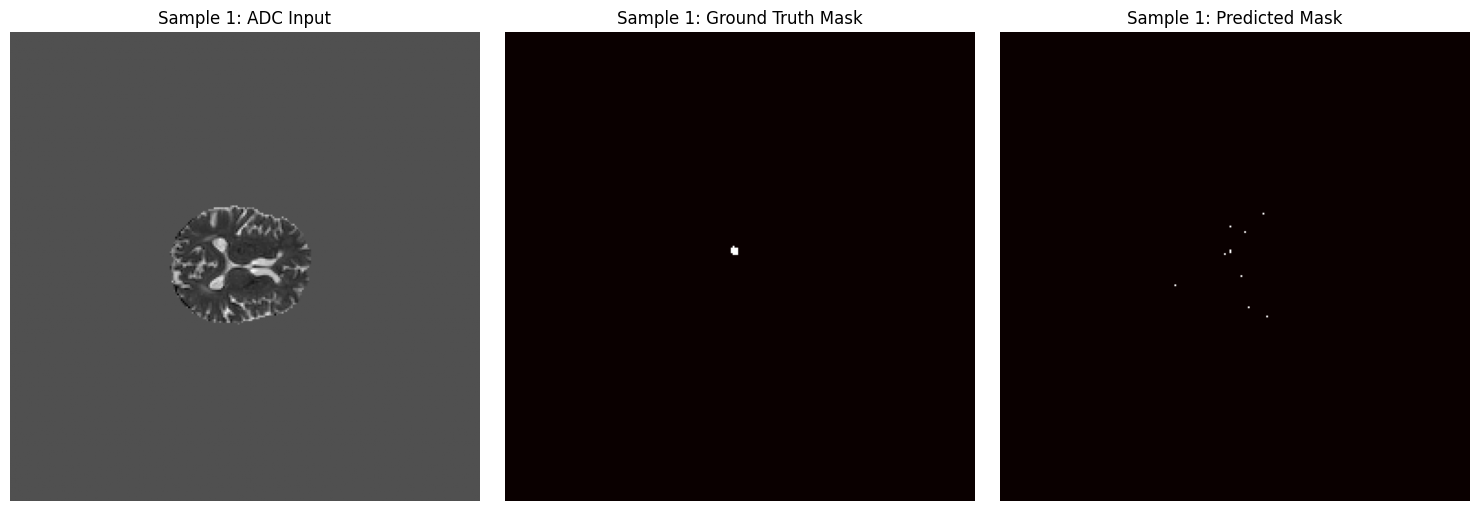

Sample 2: Predicted lesion voxels: 28371, True lesion voxels: 19252


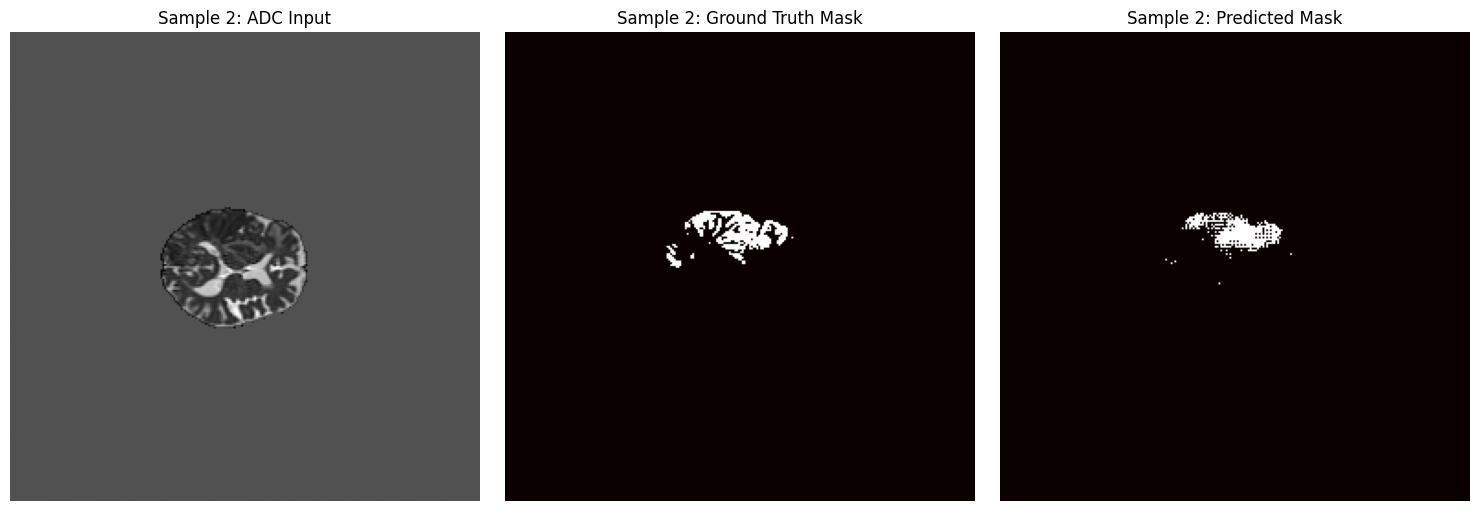

Sample 3: Predicted lesion voxels: 13558, True lesion voxels: 11689


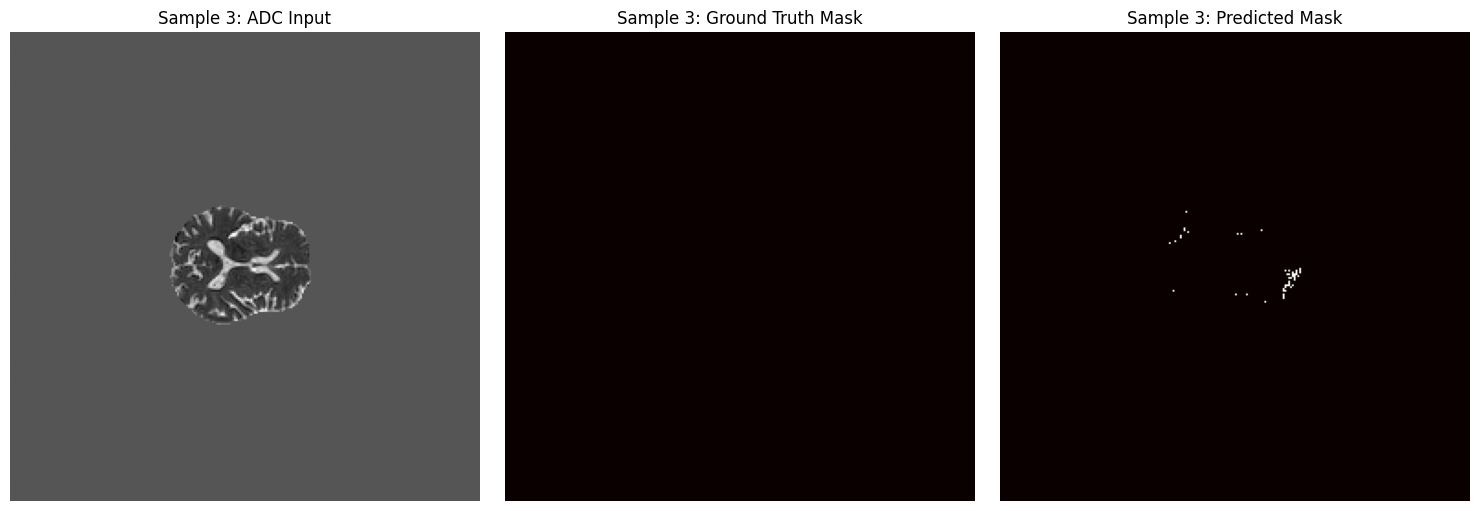

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from monai.inferers import SlidingWindowInferer

model.eval()
inferer = SlidingWindowInferer(roi_size=(128, 128, 64), sw_batch_size=1, overlap=0.25)
with torch.no_grad():
    for i, test_batch in enumerate(test_loader):
        if i >= 3:  # Check 3 samples
            break
        test_inputs = test_batch["image"].to(device)
        test_labels = test_batch["label"].to(device)
        test_outputs = inferer(test_inputs, model)
        test_outputs = post_pred(test_outputs)  # Sigmoid (tensor)
        test_outputs = post_label(test_outputs)  # Binarize (tensor)

        # Convert to NumPy for plotting
        test_outputs = test_outputs.cpu().numpy()
        test_labels = test_labels.cpu().numpy()
        test_inputs = test_inputs.cpu().numpy()

        # Print non-zero voxel count
        print(f"Sample {i+1}: Predicted lesion voxels: {np.sum(test_outputs > 0)}, True lesion voxels: {np.sum(test_labels > 0)}")

        # Plot middle slice
        slice_idx = test_labels.shape[-1] // 2
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title(f"Sample {i+1}: ADC Input")
        plt.imshow(test_inputs[0, 0, :, :, slice_idx], cmap="gray")  # ADC channel
        plt.axis("off")
        plt.subplot(1, 3, 2)
        plt.title(f"Sample {i+1}: Ground Truth Mask")
        plt.imshow(test_labels[0, 0, :, :, slice_idx], cmap="hot")
        plt.axis("off")
        plt.subplot(1, 3, 3)
        plt.title(f"Sample {i+1}: Predicted Mask")
        plt.imshow(test_outputs[0, 0, :, :, slice_idx], cmap="hot")
        plt.axis("off")
        plt.tight_layout()
        plt.savefig(f"demo_output/segmentation_demo_sample_{i+1}.png")
        plt.show()

## 📝 Saving Final Training Results to JSON

At the end of model training and evaluation, we store key performance metrics and artifact paths in a structured JSON file for easy reference and reproducibility.

### 🔧 What This Step Does:
- Captures the **final training loss**, **validation Dice score**, and **test Dice score**.
- Records the total number of **epochs trained**.
- Logs file paths for the **best saved model** and **visualization output**.
- Writes this information to a JSON file named `isles22_results.json`.

This is useful for:
- Experiment tracking and reporting
- Comparing across multiple runs
- Loading metadata during future inference or analysis

📁 **Output file:** `isles22_results.json`


In [48]:
import json

results = {
    "final_train_loss": avg_train_loss,  # From last epoch
    "final_val_dice": mean_dice,  # From last epoch
    "test_dice": mean_dice,  # From test evaluation
    "epochs_trained": 10,
    "model_path": "best_model.pth",
    "visualization_path": "segmentation_demo.png"
}
with open("isles22_results.json", "w") as f:
    json.dump(results, f, indent=4)
print("Saved results to isles22_results.json")

Saved results to isles22_results.json
